 자산 : 분기 평잔
※ 대출, 채권입고, 비상장주식 자산 제외

수익기여도 : 당사에서 발생한 거래 수수료 등 분기 수익 합산
※ 신용/대출 수익 포함 (조달금리 제외)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [186]:
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = 35
pd.options.display.max_rows = 50
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


In [815]:
act = pd.read_csv('2_act_info.csv')
cus = pd.read_csv('2_cus_info.csv')
iem = pd.read_csv('2_iem_info.csv')
trd = pd.read_csv('2_trd_kr.csv')
trd_oss = pd.read_csv('2_trd_oss.csv')
data_schema = pd.read_excel('data_schema_vf.xlsx')

In [812]:
act.head(5)

,act_id,cus_id,act_opn_ym
0,8e1a987ebef2a3374ba558aeda4c7821de7808a11cfea1...,892f41b5002a79c9c93992acf60682f5698372aea023bd...,197912
1,eb161b66263589c3f38efd2277cec2a9a81e1ffa0a5255...,006ad32069efb2a8ce1a99542dfe41cb14e8e75685278a...,198702
2,01866857515304e9e1315e54863cc1108e1d46fff0d467...,1925ed2d8ed2cad53997f5b24722482137c4d1da4b555e...,199109
3,63a58b0fee2fa4dc467c043fde465846b65705659497c5...,7829365dc463ed8275c8b92518d58b3c8d983f00f7bf87...,199401
4,b563fb76d3d432d67198f194701ca67e895da4c2f24e8e...,36e05dde058cf7531bd4001ed3b976ef9562a9ecd9f43d...,199404


In [813]:
cus.head(5)

,cus_id,sex_dit_cd,cus_age,zip_ctp_cd,tco_cus_grd_cd,ivs_icn_cd
0,1eec7e43dd6ea34d6be7a9484459e4db1a2da44c5bf311...,2,20,29,04,-
1,7e50c268acce884b1a5b78c9b5645b517c4639413c6dc4...,2,0,41,09,-
2,36d3cd293c4b02a00103fa1ba33ffbee176173a55df75b...,1,70,27,03,-
3,96b6dea03dc71d9ddb1462e06fdba23def1ddc838debf7...,1,70,41,09,-
4,034eb5406bd021a9a88f046e33765efd5b3cd190b39538...,1,70,11,05,-


In [816]:
iem.head(5)

,iem_cd,iem_eng_nm,iem_krl_nm
0,A000060,Meritz Fire & Marine Insurance ...,메리츠화재해상보험보통주 ...
1,A000120,CJ LOGISTICS ...,씨제이대한통운보통주 ...
2,A000540,HeungkukFire&MarineInsurance ...,흥국화재해상보험보통주 ...
3,A00088K,HANWHA(3PB) ...,한화3우선주(신형) ...
4,A000950,Chonbang ...,전방보통주 ...


In [817]:
trd.head()

,act_id,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd
0,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,20190102,1,12,13,A215600,2,35.00000,74200.00000,3
1,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,20190102,2,12,12,A001060,2,20.00000,41100.00000,3
2,effb34815e1b7efb34beb550f604ede8ac71a5a71edb30...,20190102,1,14,14,A281820,2,20.00000,9460.00000,4
3,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,1,12,12,A006650,2,1.00000,148500.00000,3
4,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,2,12,13,A051360,2,10.00000,6550.00000,3


In [5]:
trd.isnull().sum() # 결측치 x

act_id            0
orr_dt            0
orr_ord           0
orr_rtn_hur       0
lst_cns_hur       0
iem_cd            0
sby_dit_cd        0
cns_qty           0
orr_pr            0
orr_mdi_dit_cd    0
dtype: int64

In [819]:
trd.head(10)

,act_id,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd
0,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,20190102,1,12,13,A215600,2,35.00000,74200.00000,3
1,6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa675...,20190102,2,12,12,A001060,2,20.00000,41100.00000,3
2,effb34815e1b7efb34beb550f604ede8ac71a5a71edb30...,20190102,1,14,14,A281820,2,20.00000,9460.00000,4
3,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,1,12,12,A006650,2,1.00000,148500.00000,3
4,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,2,12,13,A051360,2,10.00000,6550.00000,3
5,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,3,12,13,A051360,2,10.00000,6560.00000,3
6,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,4,12,13,A051360,2,10.00000,6570.00000,3
7,fea6c038cb7236a02d1e779262698a36219b4c9b527ab1...,20190102,5,12,14,A018260,2,1.00000,205000.00000,3
8,6dee1607a1b1c6ae828eb8c84bef0ef963776eb06163a7...,20190102,1,13,13,A074610,2,5.00000,5480.00000,3
9,6dee1607a1b1c6ae828eb8c84bef0ef963776eb06163a7...,20190102,2,14,14,A074610,2,5.00000,5450.00000,3


In [6]:
print('trd 데이터 내 계좌 수는 {0}개'.format(trd['act_id'].nunique()))

trd 데이터 내 계좌 수는 10997개


In [419]:
print('계좌 수', act['act_id'].nunique())  # 계좌 수
print('고객 수', act['cus_id'].nunique())  # 고객 수 

계좌 수 23959
고객 수 10000


In [10]:
iem = iem.sort_values(by = 'iem_cd')

In [11]:
iem.index = range(len(iem))

In [12]:
iem['종목코드'] = ''
iem['첫글자'] = ''

In [13]:
for i in range(len(iem)):
    x = 1
    while iem['iem_cd'][i][:x].isalpha():
        iem['첫글자'][i] = iem['iem_cd'][i][:x].strip()
        iem['종목코드'][i] = iem['iem_cd'][i][x:].strip()
        x += 1


In [16]:
import requests
from bs4 import BeautifulSoup as bs

In [18]:
trd.describe()

,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd
count,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000
mean,20196206.05021,32.00546,11.08755,11.32544,1.64386,388.25390,30076.22491,3.16434
std,4829.95027,83.04192,2.11567,2.13135,0.47886,4369.01490,66044.14501,0.51305
min,20190102.00000,1.00000,7.00000,7.00000,1.00000,1.00000,1.00000,1.00000
25%,20190807.00000,3.00000,9.00000,9.00000,1.00000,5.00000,3815.00000,3.00000
50%,20200211.00000,8.00000,11.00000,11.00000,2.00000,31.00000,8560.00000,3.00000
75%,20200504.00000,25.00000,13.00000,13.00000,2.00000,200.00000,28500.00000,3.00000
max,20200630.00000,1688.00000,18.00000,18.00000,2.00000,2400000.00000,1810000.00000,4.00000


In [19]:
trd['주문날짜'] = trd['orr_dt'].apply(lambda x : datetime.datetime.strptime(str(x), '%Y%m%d')) # datetime 형식으로 변환

In [20]:
trd['년'] = trd['주문날짜'].apply(lambda x : x.year) # 년/월/일 뽑아줌
trd['월'] = trd['주문날짜'].apply(lambda x : x.month)
trd['일'] = trd['주문날짜'].apply(lambda x : x.day)

In [21]:
trd.drop('orr_dt', axis = 1 , inplace = True) # 기존 날짜 컬럼 삭제

In [23]:
trd['체결비용'] = trd['cns_qty']*trd['orr_pr'] # 체결 수량 x 체결 가격으로 체결 비용 산출

In [24]:
## 테마별 종목 크롤링 출처 : 네이버 금융

theme_dict = dict()

for page in range(1,7):
    
    url = 'https://finance.naver.com/sise/theme.nhn?&page='
    address = url + str(page)
    res = requests.get(address)
    html = res.content
    soup = bs(html, 'html.parser')

    datas = soup.select('#contentarea_left > table.type_1.theme td.col_type1')

    for data in datas:
        
        theme_dict[data.text] = 'finance.naver.com' + data.find('a')['href']


theme_stock_dict = dict()
for theme in theme_dict.keys():
    url = theme_dict[theme]
    res = requests.get('https://' + url)
    html = res.content
    soup = bs(html, 'html.parser')


    stocks = soup.select('tbody td.name')
    stock_list = []
    for stock in stocks:
        stock_list.append(stock.text.replace('*','').strip())
    theme_stock_dict[theme] = stock_list

In [25]:
## 업종별 종목 크롤링 출처 : 네이버 금융

cat_dict = dict()



url = 'https://finance.naver.com/sise/sise_group.nhn?type=upjong'
res = requests.get(url)
html = res.content
soup = bs(html, 'html.parser')


datas = soup.select('table tr')

del datas[0]
del datas[0]
del datas[0]

for data in datas:
    if data.select_one('td').text:
        cat_dict[data.select_one('td').text] = 'finance.naver.com' + data.select_one('td').find('a')['href']
    else:
        pass

    
    
cat_stock_dict = dict()
for cat in cat_dict.keys():
    url = cat_dict[cat]
    res = requests.get('https://' + url)
    html = res.content
    soup = bs(html, 'html.parser')


    stocks = soup.select('table td.name')

    stock_list = []
    for stock in stocks:
            stock_list.append(stock.text.replace('*','').strip())
    cat_stock_dict[cat] = stock_list


In [26]:
# 종목명에 '보통주', '우선주' 포함되어 있는 애들 분리 시켜줌

iem['name'] = ''
iem['보통주/우선주'] = ''

for i in range(len(iem)):
    if '보통주' in iem['iem_krl_nm'][i]:
        iem['name'][i] = iem['iem_krl_nm'][i].replace('보통주', '').strip()
        iem['보통주/우선주'][i] = '보통주'
    elif '우선주' in iem['iem_krl_nm'][i]:
        iem['name'][i] = iem['iem_krl_nm'][i].replace('우선주', '').replace('(신형)', '').strip()
        iem['보통주/우선주'][i] = '우선주'
    else:
        iem['name'][i] = iem['iem_krl_nm'][i].strip()
        iem['보통주/우선주'][i] = '없음'

In [109]:
iem['업종'] = ''


    
for cat in cat_stock_dict.keys():
    for j in range(len(iem)):
        if iem.loc[j, 'name'] in cat_stock_dict[cat]:
            iem['업종'][j] = cat

In [92]:
iem['테마'] = ''

for i in range(len(iem)):
    iem.loc[i,'테마'] = []

    
for theme in theme_stock_dict.keys():
    for j in range(len(iem)):
        if iem.loc[j, 'name'] in theme_stock_dict[theme]:
            iem['테마'][j].append(theme)    

In [27]:
iem.head(5)

,iem_cd,iem_eng_nm,iem_krl_nm,종목코드,첫글자,name,보통주/우선주
0,A000020,DongwhaPharm ...,동화약품보통주 ...,000020,A,동화약품,보통주
1,A000030,Woori Bank ...,우리은행보통주 ...,000030,A,우리은행,보통주
2,A000040,KR MOTORS ...,KR모터스보통주 ...,000040,A,KR모터스,보통주
3,A000050,Kyungbang ...,경방보통주 ...,000050,A,경방,보통주
4,A000060,Meritz Fire & Marine Insurance ...,메리츠화재해상보험보통주 ...,000060,A,메리츠화재해상보험,보통주


In [29]:
df_trd = trd.copy()

In [116]:
# 제공된 데이터들을 하나로 병합시켜줌

merge = pd.merge(df_trd, iem, how = 'left', left_on = 'iem_cd', right_on = 'iem_cd') # 종목 정보 + 트레이드
merge2 = pd.merge(merge, act, how = 'left', left_on = 'act_id', right_on = 'act_id') # + 계좌정보
merge3 = pd.merge(merge2, cus, how = 'left', left_on = 'cus_id', right_on = 'cus_id') #  + 개인 정보

In [117]:
merge3.columns

Index(['act_id', 'orr_ord', 'orr_rtn_hur', 'lst_cns_hur', 'iem_cd',
       'sby_dit_cd', 'cns_qty', 'orr_pr', 'orr_mdi_dit_cd', '주문날짜', '년', '월',
       '일', '체결비용', 'iem_eng_nm', 'iem_krl_nm', '종목코드', '첫글자', 'name',
       '보통주/우선주', '테마', '업종', 'cus_id', 'act_opn_ym', 'sex_dit_cd', 'cus_age',
       'zip_ctp_cd', 'tco_cus_grd_cd', 'ivs_icn_cd'],
      dtype='object')

In [118]:
merge3.shape

(3312664, 29)

In [119]:
merge3['첫글자'].value_counts()

A       3276654
Q         22606
J         13365
JHKG         23
F             9
JCYM          7
Name: 첫글자, dtype: int64

In [120]:
merge3.describe()

,orr_ord,orr_rtn_hur,lst_cns_hur,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd,년,월,일,체결비용,act_opn_ym,sex_dit_cd,cus_age
count,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000,3312664.00000
mean,32.00546,11.08755,11.32544,1.64386,388.25390,30076.22491,3.16434,2019.56695,5.20351,16.21412,2579866.20285,201471.15931,1.37338,45.72144
std,83.04192,2.11567,2.13135,0.47886,4369.01490,66044.14501,0.51305,0.49550,2.89122,8.54680,21378209.31364,642.21526,0.48370,11.73498
min,1.00000,7.00000,7.00000,1.00000,1.00000,1.00000,1.00000,2019.00000,1.00000,1.00000,2.00000,197603.00000,1.00000,0.00000
25%,3.00000,9.00000,9.00000,1.00000,5.00000,3815.00000,3.00000,2019.00000,3.00000,9.00000,73500.00000,201309.00000,1.00000,35.00000
50%,8.00000,11.00000,11.00000,2.00000,31.00000,8560.00000,3.00000,2020.00000,5.00000,17.00000,405000.00000,201711.00000,1.00000,45.00000
75%,25.00000,13.00000,13.00000,2.00000,200.00000,28500.00000,3.00000,2020.00000,6.00000,24.00000,1618400.00000,201902.00000,2.00000,55.00000
max,1688.00000,18.00000,18.00000,2.00000,2400000.00000,1810000.00000,4.00000,2020.00000,12.00000,31.00000,10167500000.00000,202006.00000,2.00000,70.00000


### 체결비용이 평균 257만인데 비해 표준편차가 2천만이고 2분위수가 40만. max 비용이 100억을 넘음.

In [121]:
merge3['spend_time'] = merge3['lst_cns_hur'] - merge3['orr_rtn_hur'] # 주문접수 ~ 최종 체결 소요 시간

In [122]:
merge3['spend_time'].value_counts()

0    2814394
1     350843
2      72931
3      34067
4      21291
5      12341
6       5468
7       1155
8        173
9          1
Name: spend_time, dtype: int64

In [265]:
# 컬럼명 재설정
merge3.columns = ['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드',
       '매매구분코드', '체결수량', '체결가격', '주문매체구분코드', '주문날짜', '년', '월',
       '일', '체결비용(체결수량 x 체결가격)', '종목 영어명', '종목 한글명', '종목코드', '첫글자',
       '종목명(보통주_우선주 제외)', '보통주/우선주', '테마', '업종', '고객번호', '계좌 개설 년월', '성별', '연령대',
       '주소(시도)', '고객등급', '고객투자성향',
       '소요시간(최종체결시간대 - 주문접수시간대)']

In [254]:
merge3['종목 한글명'] = merge3['종목 한글명'].apply(lambda x: x.strip())
merge3['종목 영어명'] = merge3['종목 영어명'].apply(lambda x: x.strip())

### 연령대별 총거래금액

#### why 35~40에서 갑자기 상승?

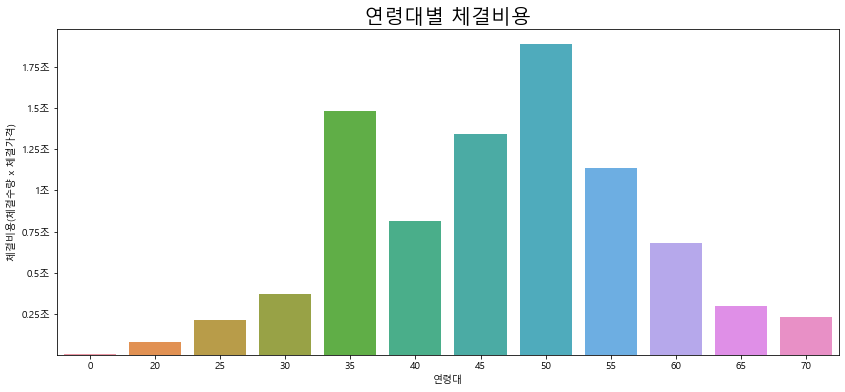

In [818]:
age_price = merge3.groupby('연령대')['체결비용(체결수량 x 체결가격)'].sum()
age_price = pd.DataFrame(age_price)
age_price = age_price.sort_values(by = '연령대')

x = age_price.index
y = age_price['체결비용(체결수량 x 체결가격)']

fig, ax = plt.subplots(figsize = (14,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

ax.set_yticks([250000000000,500000000000,750000000000,1000000000000,1250000000000,1500000000000,1750000000000])
ax.set_yticklabels(['0.25조', '0.5조', '0.75조', '1조', '1.25조', '1.5조', '1.75조'])

plt.title('연령대별 체결비용', fontsize = 20)
# plt.savefig('연령대별 체', dpi = 300)
plt.show()

In [447]:
age_35 = merge3[merge3['연령대'] == 35]
age_35.index = range(len(age_35))

In [466]:
age_35['년월'] = age_35['주문날짜'].apply(lambda x : x.strftime('%Y%m'))

<ipython-input-466-424c564c096e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_35['년월'] = age_35['주문날짜'].apply(lambda x : x.strftime('%Y%m'))


### 2020년 4월부터 갑자기 거래비용이 널뛰기함

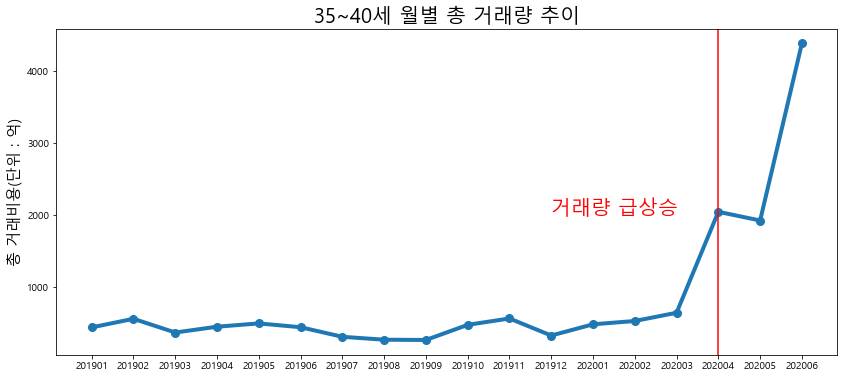

In [672]:
data = age_35.groupby(['년월'])['체결비용(체결수량 x 체결가격)'].sum()
x = data.index
y = data/100000000

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(x,y, lw = 4, marker = 'o', markersize = 8)
ax.set_ylabel('총 거래비용(단위 : 억)', fontsize = 15)
plt.title('35~40세 월별 총 거래량 추이', fontsize = 20)
plt.axvline(x = 15, color = 'red')
plt.text(11,2000, '거래량 급상승', fontsize= 20, color = 'red')
plt.show()

### 근데 전연령으로 보면 이미 코로나 터지고 1월부터 서서히 증가하고 있긴 했음
### 오히려 35~40은 더 늦은 4월에 갑자기 몰려든 느낌

In [ ]:
merge3['년월'] = ''
merge3['년월'] = merge3['주문날짜'].apply(lambda x : x.strftime('%Y%m'))

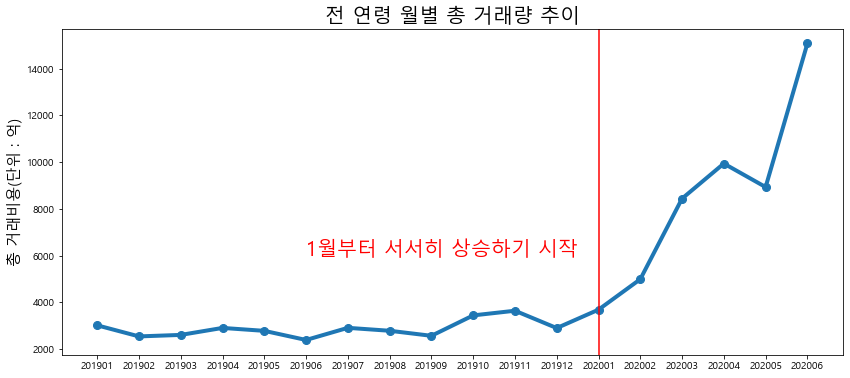

In [673]:
data = merge3.groupby(['년월'])['체결비용(체결수량 x 체결가격)'].sum()
x = data.index
y = data/100000000

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(x,y, lw = 4, marker = 'o', markersize = 8)
ax.set_ylabel('총 거래비용(단위 : 억)', fontsize = 15)
plt.title('전 연령 월별 총 거래량 추이', fontsize = 20)
plt.axvline(x = 12, color = 'red')
plt.text(5,6000, '1월부터 서서히 상승하기 시작', fontsize= 20, color = 'red')
plt.show()

### 전반적으로 모든 연령대에서 20년 이후 급격한 상승세를 보임
### 20세 미만과, 20 ~ 25 / 25 ~ 30 / 30 ~ 35 / 35 ~ 40 / 45 ~ 50 들은 2019년 12월 대비 2020년 6월에 5배 이상 증가했음!
### 이런 증가세가 새로운 투자자 유입량에 따른건지 기존 투자자들의 투자 금액이 커진건지 알아봐야 할 듯


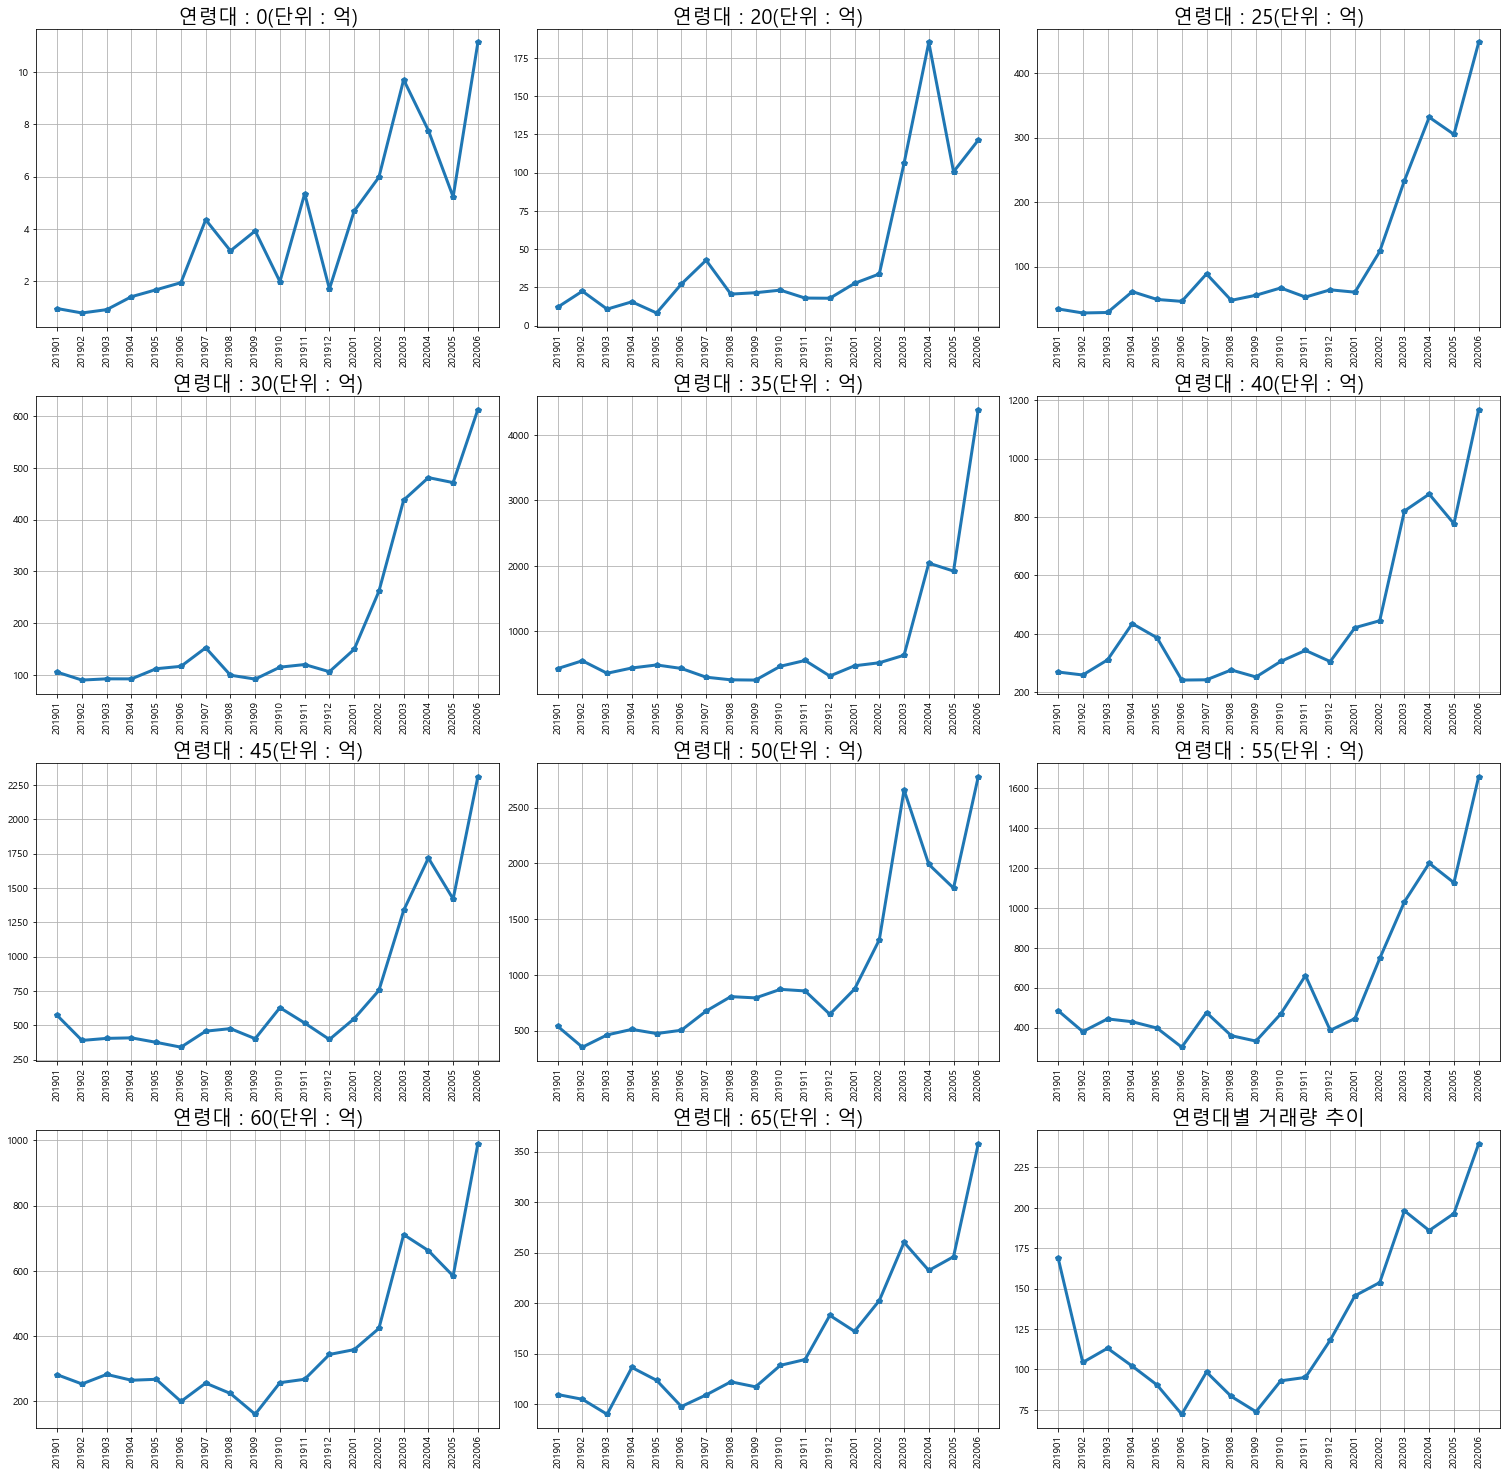

In [675]:
age_list = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (21,20))
fig.tight_layout(h_pad = 5)
for i, age in enumerate(age_list):
    data = merge3[merge3['연령대'] == age]
    data = data.groupby(['년월'])['체결비용(체결수량 x 체결가격)'].sum()
    
    
    
    col = i % 3
    row = i // 3
    
    x = data.index
    y = data/100000000
    
    ax[row,col].plot(x,y, lw = 3, marker = 'p')
    ax[row,col].set_xticks(range(len(x)))
    ax[row,col].set_xticklabels(x, rotation = 90)
    
    ax[row,col].set_title("연령대 : {0}(단위 : 억)".format(age), fontsize= 20)
    ax[row,col].grid()
# fig.savefig('연령대별 종목 총거래금액  Top5.png', dpi = 300, bbox_inches = "tight")

plt.show()

In [611]:
# 계좌 정보와 개인 정보를 병합
act_cus = pd.merge(act,cus, how ='left', left_on = 'cus_id', right_on = 'cus_id')

### 계좌를 몇십개씩 가지고 있는 애들.. 왜지?

In [634]:
act_cus['cus_id'].value_counts()

607b5194a54ec30991a86a4dee5a6e2a85924244fde2e0047d4917db2e93452f    69
ec428694f9bbe24e0591b205d1c266f5219b1794accb2c38e8278f3b9304bdb8    56
f595722537a7aac0ba585bd79dbf95a8f3a1a8d251500ba82e3e360fc0f245e9    52
5c698909252796a56118ddb12ed49dea5402cfd7c1960a5c97ecae772d4e5601    46
af887d5a0db31c53f761ea4ac34d33afa8572d892b2809ae5c97cdde78fe973e    45
                                                                    ..
e62e1b77d9258bb8694b6fbaf1393ee00a78408554b38126ef526bd3c097b58e     1
669d5b0f30c36f28a4efc03d58dbdde3b35d57b7385c74a9b6f4d7ef97683a84     1
6387b1eb4ee90ddfb4a6ac7d3ffc28308d7f4bd7c476de97d4e999c2762550a6     1
29af244c12fea9df09b21e826404e8c5c5ab85578ff67b623c9735e83202b091     1
e5655729c02ce22e12346e92f4dc3bee7be62f80453b0aba6947dea5f63a951b     1
Name: cus_id, Length: 10000, dtype: int64

### <월별 개설된 계좌 수>
#### 의도적으로 제공된 것인지는 모르지만 제공된 데이터들은 2020년 3월에 매우 많은 신규 계좌들이 생겨났고
#### 2020년 2월, 4월, 5월, 6월에도 많이 개설되었다가 7월에 들어서면서 다시 감소하는 추세를 보였다

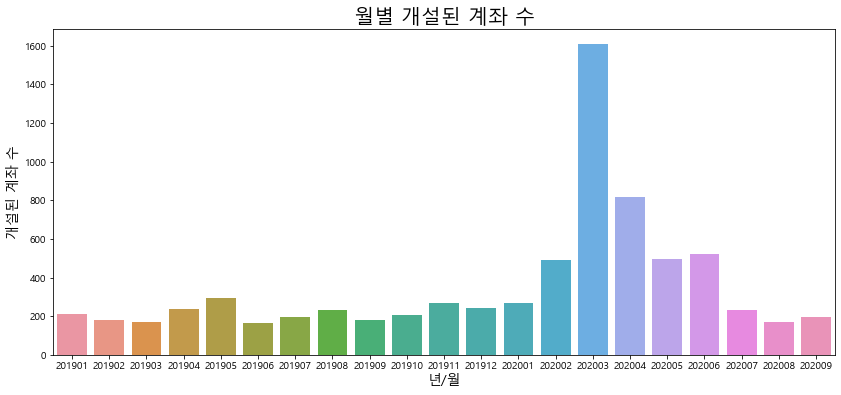

In [676]:
data = act_cus.groupby('act_opn_ym')['act_id'].count()[-22:-1]
x = data.index
y = data

fig, ax = plt.subplots(figsize = (14,6))

sns.barplot(x,y)

ax.set_title('월별 개설된 계좌 수', fontsize = 20)

ax.set_ylabel('개설된 계좌 수', fontsize = 14)
ax.set_xlabel('년/월', fontsize = 14)
plt.show()

In [683]:
act_cus['년'] = ''
act_cus['년'] = act_cus['act_opn_ym'].apply(lambda x : str(x)[:4])

In [698]:
act_cus_age_num = act_cus.groupby(['년','cus_age'], as_index = False)['act_id'].count()

In [708]:
act_cus_age_num = act_cus_age_num[act_cus_age_num['년'].isin(['2018','2019','2020'])]

In [720]:
act_cus_age_num_18 = act_cus_age_num[act_cus_age_num['년']=='2018']
act_cus_age_num_18['비율'] = ''
act_cus_age_num_18['비율'] = act_cus_age_num_18['act_id'] / act_cus_age_num_18['act_id'].sum() * 100

act_cus_age_num_19 = act_cus_age_num[act_cus_age_num['년']=='2019']
act_cus_age_num_19['비율'] = ''
act_cus_age_num_19['비율'] = act_cus_age_num_19['act_id'] / act_cus_age_num_19['act_id'].sum() * 100

act_cus_age_num_20 = act_cus_age_num[act_cus_age_num['년']=='2020']
act_cus_age_num_20['비율'] = ''
act_cus_age_num_20['비율'] = act_cus_age_num_20['act_id'] / act_cus_age_num_20['act_id'].sum() * 100

<ipython-input-720-731c786415f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_cus_age_num_18['비율'] = ''
<ipython-input-720-731c786415f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act_cus_age_num_18['비율'] = act_cus_age_num_18['act_id'] / act_cus_age_num_18['act_id'].sum() * 100
<ipython-input-720-731c786415f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [753]:
data = pd.concat([act_cus_age_num_18,act_cus_age_num_19,act_cus_age_num_20])

### 19년과 20년 개설된 계좌의 연령대 비율 비교
#### 미성년자(20세미만) / 20 ~ 35세까지 1% 가량의 작은 증가세를 보이고 60 ~ 65 구간에서 2% 가량 감소세를 나타냄
#### 이게 의미 있는 수치인가?

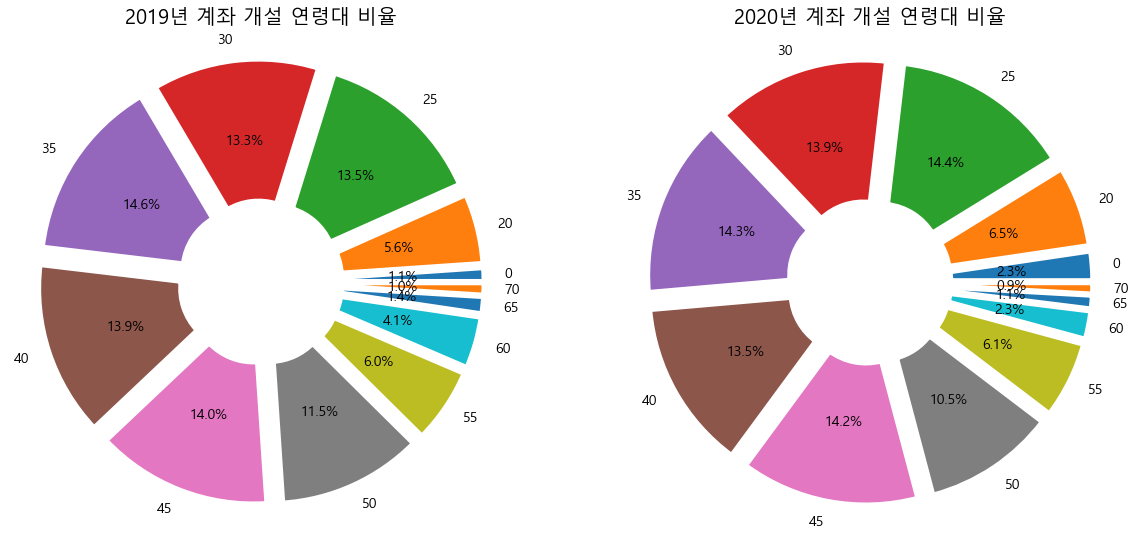

In [797]:
fig,ax = plt.subplots(figsize = (20,10), ncols = 2, nrows = 1)

y = act_cus_age_num_19['비율']
x = act_cus_age_num_19['cus_age']

explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
textprops={'fontsize' : 14}

ax[0].pie(y, labels = x, autopct='%0.1f%%', explode = explode, wedgeprops = wedgeprops, textprops = textprops)
ax[0].set_title('2019년 계좌 개설 연령대 비율', fontsize = 20)



y = act_cus_age_num_20['비율']
x = act_cus_age_num_20['cus_age']

explode = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
textprops={'fontsize' : 14}

ax[1].pie(y, labels = x, autopct='%0.1f%%', explode = explode, wedgeprops = wedgeprops, textprops = textprops)
ax[1].set_title('2020년 계좌 개설 연령대 비율', fontsize = 20)
plt.show()

### 그렇다면 20년대 계좌 개설한 사람들은 어디다 투자를 했을까?
### 20년 개설한 사람들과 그 이외의 사람들의 투자 종목을 비교해봐야할듯

In [803]:
opn20_act = list(act_cus[act_cus['년'] == '2020']['act_id']) # 20년대 계좌 개설한 사람들 계좌번호
opn20_act_trd = merge3[merge3['계좌번호'].isin(opn20_act)]

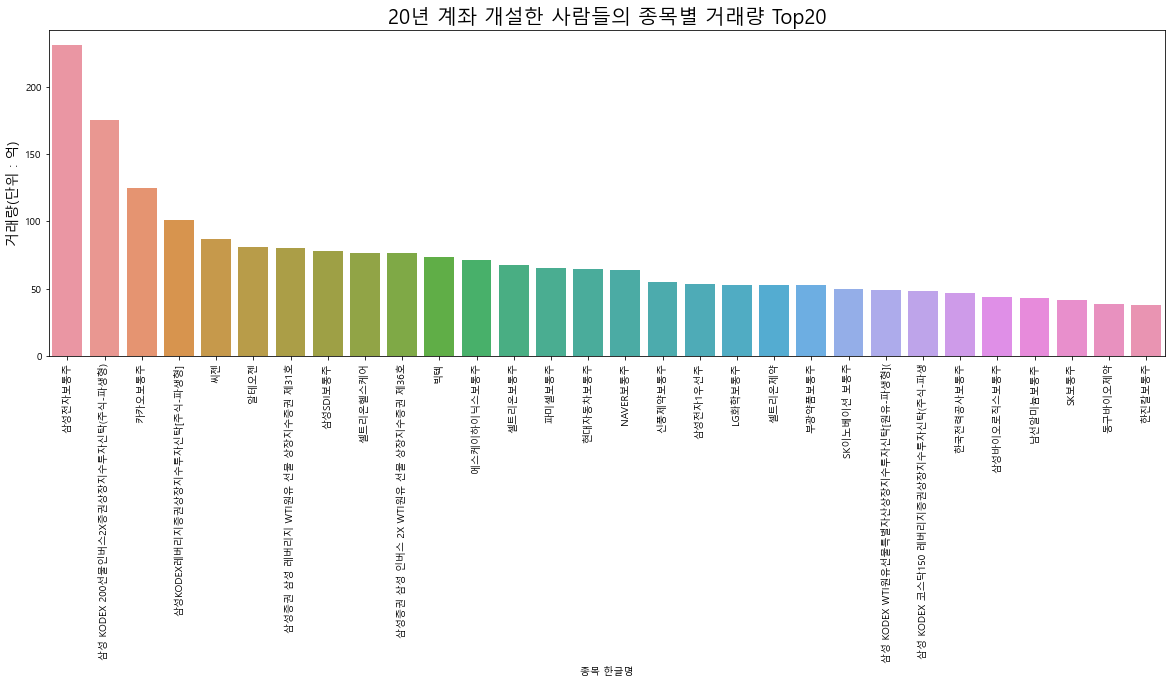

In [810]:
iem_price_opn20 = opn20_act_trd.groupby('종목 한글명')['체결비용(체결수량 x 체결가격)'].sum().sort_values(ascending = False)[:30]
iem_price_opn20 = pd.DataFrame(iem_price_opn20)

x = iem_price_opn20.index
y = iem_price_opn20['체결비용(체결수량 x 체결가격)'] / 100000000

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 90)
# ax.set_yticks([50000000000,100000000000,150000000000,200000000000,250000000000])
# ax.set_yticklabels(['500억', '1000억', '1500억', '2000억', '2500억'])
ax.set_ylabel('거래량(단위 : 억)', fontsize= 14)
plt.title('20년 계좌 개설한 사람들의 종목별 거래량 Top20', fontsize = 20)
plt.savefig('20년 계좌 개설한 사람들의 종목별 거래량 Top20.png', dpi = 300)
plt.show()

### 종목별 총 거래금액 Top 30

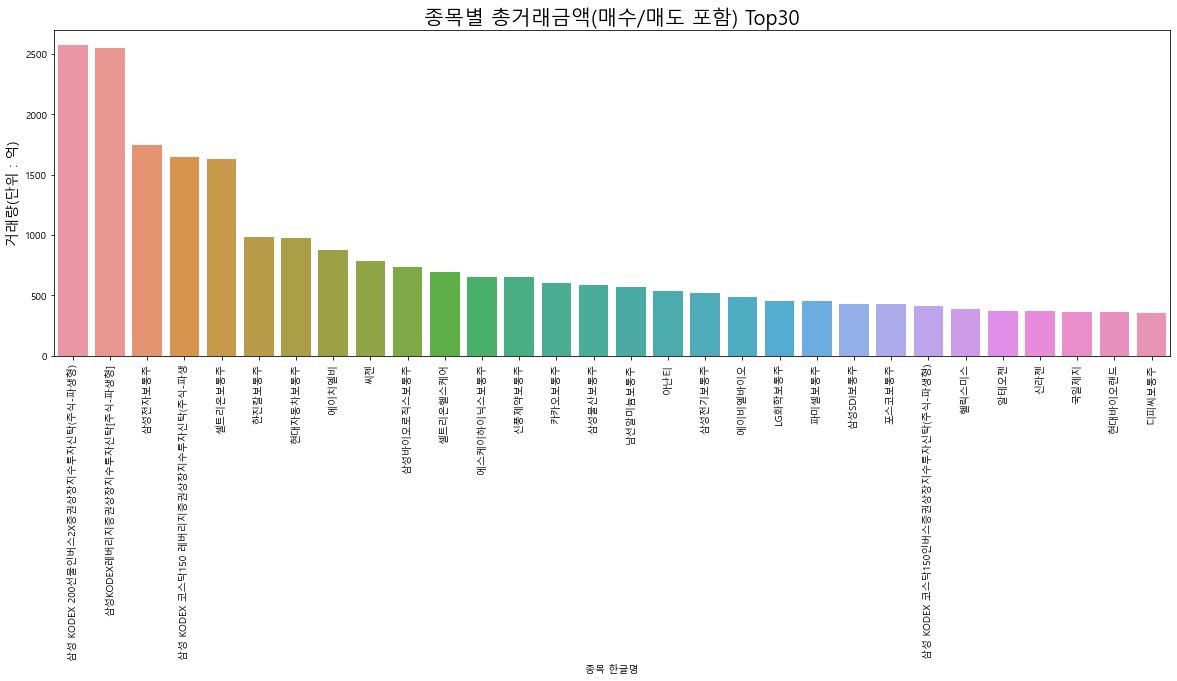

In [811]:
iem_price = merge3.groupby('종목 한글명')['체결비용(체결수량 x 체결가격)'].sum().sort_values(ascending = False)[:30]
iem_price = pd.DataFrame(iem_price)

x = iem_price.index
y = iem_price['체결비용(체결수량 x 체결가격)'] / 100000000

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 90)
# ax.set_yticks([50000000000,100000000000,150000000000,200000000000,250000000000])
# ax.set_yticklabels(['500억', '1000억', '1500억', '2000억', '2500억'])
ax.set_ylabel('거래량(단위 : 억)', fontsize= 14)
plt.title('종목별 총거래금액(매수/매도 포함) Top30', fontsize = 20)
plt.savefig('종목별 총거래금액(매수_매도 포함) Top30.png', dpi = 300)
plt.show()


In [287]:
iem_list = list(set(merge3['종목 한글명']))
ETF_list = ['KODEX', 'TIGER', 'KBSTAR', 'ARIRANG', 'KINDEX', 'KOSEF']
ETF_name = []

for iem in iem_list:
    for ETF in ETF_list:
        if ETF in iem:
            ETF_name.append(iem)

In [832]:
ETF = merge3[merge3['종목 한글명'].isin(ETF_name)]

In [295]:
drop_ETF = merge3.drop(ETF.index)

In [834]:
ETF.columns = ['계좌번호', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결수량', '체결가격',
       '주문매체구분코드', '주문날짜', '년', '월', '일', '체결비용(체결수량 x 체결가격)', '종목 영어명',
       '종목 한글명', '종목코드(알파벳 제외)', '첫글자', '종목명(보통주_우선주 제외)', '보통주/우선주', '테마', '업종',
       '고객번호', '계좌 개설 년월', '성별', '연령대', '주소(시도)', '고객등급', '고객투자성향',
       '소요시간(최종체결시간대 - 주문접수시간대)', '년월']

ETF['종목코드'].value_counts()

A252670         31945
A122630         25215
A233740         17195
A261220          6226
A251340          5176
                ...  
A176950             1
A266140             1
A253280             1
A309230             1
A253240             1
Name: 종목코드, Length: 277, dtype: int64

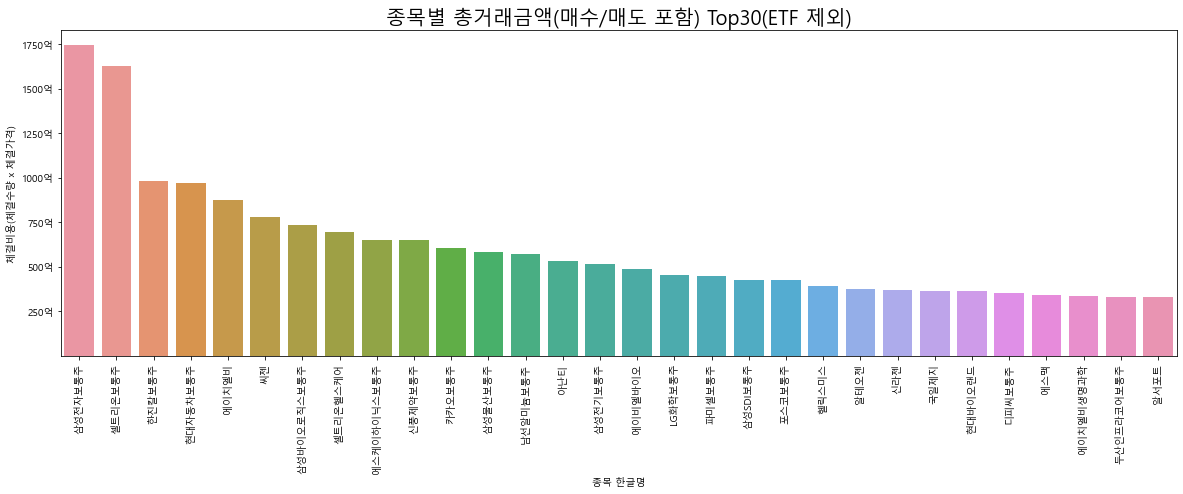

In [302]:
iem_price_ex_ETF = drop_ETF.groupby('종목 한글명')['체결비용(체결수량 x 체결가격)'].sum().sort_values(ascending = False)[:30]
iem_price_ex_ETF = pd.DataFrame(iem_price_ex_ETF)

x = iem_price_ex_ETF.index
y = iem_price_ex_ETF['체결비용(체결수량 x 체결가격)']

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation = 90)
ax.set_yticks([25000000000,50000000000,75000000000,100000000000,125000000000,150000000000, 175000000000])
ax.set_yticklabels(['250억', '500억', '750억', '1000억', '1250억','1500억', '1750억'])
plt.title('종목별 총거래금액(매수/매도 포함) Top30(ETF 제외)', fontsize = 20)
plt.savefig('종목별 총거래금액(매수_매도 포함) Top30(ETF 제외).png', dpi = 300)
plt.show()


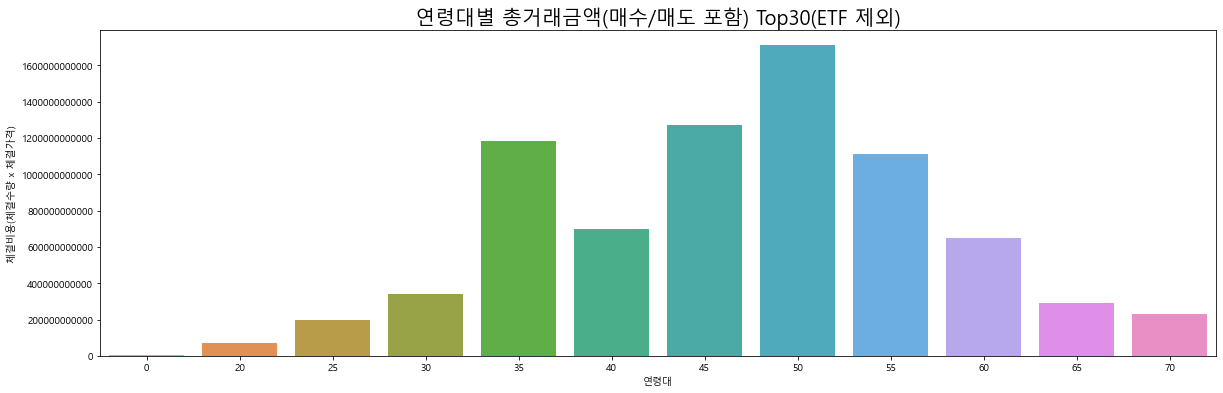

In [836]:
age_price_ex_ETF = drop_ETF.groupby('연령대')['체결비용(체결수량 x 체결가격)'].sum()
age_price_ex_ETF = pd.DataFrame(age_price_ex_ETF)

x = age_price_ex_ETF.index
y = age_price_ex_ETF['체결비용(체결수량 x 체결가격)']

fig, ax = plt.subplots(figsize = (20,6))
                       
sns.barplot(x,y)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x)
# ax.set_yticks([25000000000,50000000000,75000000000,100000000000,125000000000,150000000000, 175000000000])
# ax.set_yticklabels(['250억', '500억', '750억', '1000억', '1250억','1500억', '1750억'])
plt.title('연령대별 총거래금액(매수/매도 포함) Top30(ETF 제외)', fontsize = 20)
# plt.savefig('종목별 총거래금액(매수_매도 포함) Top30(ETF 제외).png', dpi = 300)
plt.show()


In [308]:
age_iem_price = merge3.groupby(['연령대','종목 한글명'], as_index = False).agg({'체결비용(체결수량 x 체결가격)' : 'sum'})

In [353]:
x = age_iem_price[age_iem_price['연령대'] == 25]
x

,연령대,종목 한글명,체결비용(체결수량 x 체결가격)
2439,25,(주)마이크로컨텍솔루션,1273735.00000
2440,25,(주)스카이이앤엠,84714695.00000
2441,25,(주)포스코엠텍,252099525.00000
2442,25,AJ네트웍스보통주,18600440.00000
2443,25,BGF리테일보통주,25400000.00000
...,...,...,...
4745,25,흥국화재해상보험2우선주(신형),13956050.00000
4746,25,흥국화재해상보험보통주,33996390.00000
4747,25,흥아해운보통주,69131990.00000
4748,25,희림종합건축사사무소,6255780.00000


C:\Users\msi\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\msi\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\msi\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

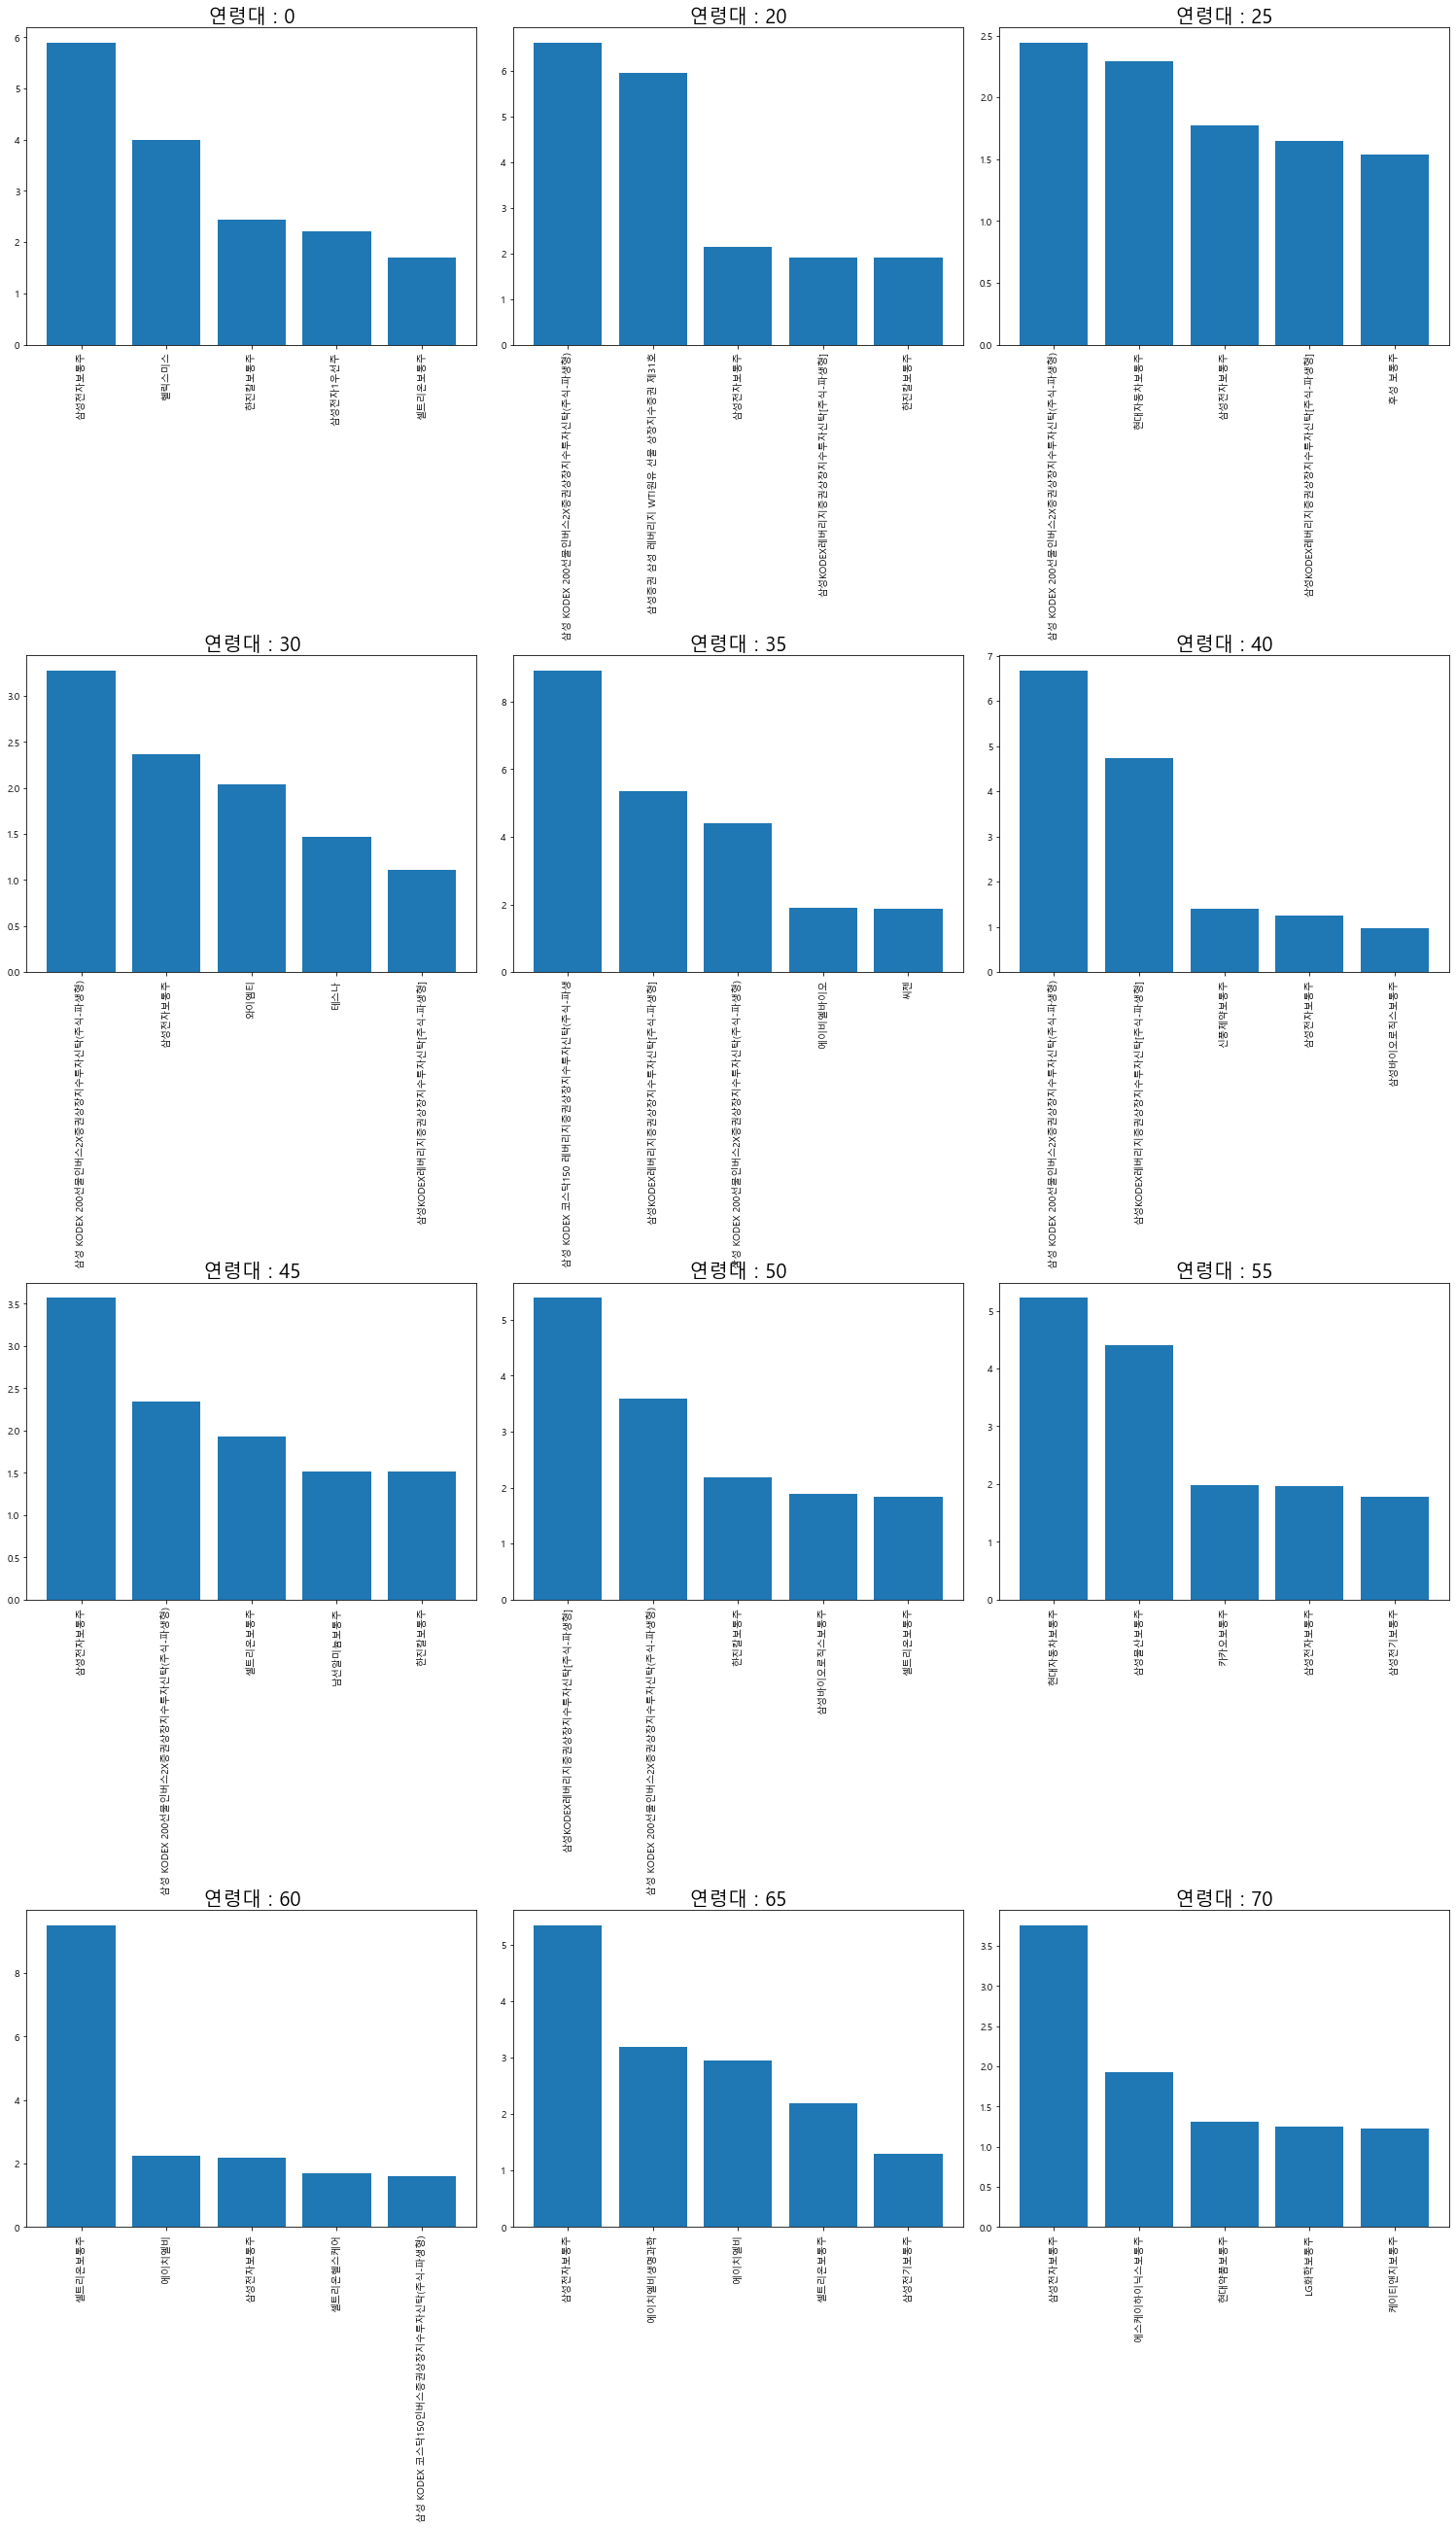

In [369]:
age_list = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize = (21, 32))
fig.tight_layout(h_pad = 30)
for i,age in enumerate(age_list):
    data = age_iem_price[age_iem_price['연령대'] == age]
    data.loc[:,'비율'] = data.loc[:,'체결비용(체결수량 x 체결가격)'] / data.loc[:,'체결비용(체결수량 x 체결가격)'].sum() * 100
    data = data.sort_values(by = '비율', ascending = False)[:5]
    
    col = i % 3
    row = i // 3
    
    x = data['종목 한글명']
    y = data['비율']
    
    ax[row,col].bar(x,y)
    ax[row,col].set_xticks(range(len(x)))
    ax[row,col].set_xticklabels(x, rotation = 90, fontsize = 10)
    
    ax[row,col].set_title("연령대 : {0}".format(age), fontsize= 20)
fig.savefig('연령대별 종목 총거래금액  Top5.png', dpi = 300, bbox_inches = "tight")
plt.show()

## 55세 이상부터는 ETF가 아예 사라지거나 비율이 적어지는 것을 볼 수 있었음
## 유입자들 ETF 비율 비교해보기